# Setup

In [3]:
# run this code, then re-start runtime 
!python -m spacy download en_core_web_md &> /dev/null

In [4]:
import spacy
# md: reduced word vector table with 20k unique vectors for ~500k words
nlp = spacy.load("en_core_web_md") # IF THIS DOESN'T WORK, THEN RUN THE CODE ABOVE^ & RE-START RUNTIME

ModuleNotFoundError: No module named 'spacy'

In [2]:
# import dependencies
import pandas as pd
import numpy as np
import nltk
import re
import itertools
import matplotlib.pyplot as plt

## nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
from nltk import pos_tag

# spacy
import spacy
# md: reduced word vector table with 20k unique vectors for ~500k words

## sklearn
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer 
from sklearn.metrics import classification_report,confusion_matrix, accuracy_score, f1_score, precision_score, recall_score, plot_confusion_matrix
from sklearn.svm import LinearSVC
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from sklearn.linear_model import SGDClassifier, LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn import tree
from sklearn.ensemble import AdaBoostClassifier
from sklearn.datasets import make_classification
from sklearn.pipeline import Pipeline

# xgboost
from xgboost import XGBClassifier

## joblib
from joblib import dump, load

##ensemble learning
from sklearn.ensemble import VotingClassifier

# set seed
np.random.seed(42)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [3]:
# load data 
train = pd.read_csv('https://raw.githubusercontent.com/smkerr/COVID-fake-news-detection/main/data/Constraint_Train.csv', header=0)
val = pd.read_csv('https://raw.githubusercontent.com/smkerr/COVID-fake-news-detection/main/data/Constraint_Val.csv', header=0)
#test = pd.read.csv('https://raw.githubusercontent.com/smkerr/COVID-fake-news-detection/main/data/Constraint_Test.csv', header=0)

In [ ]:
#print(f"The training set contains {len(train)} observations.")
#train.head()

In [4]:
# Define X & y for train, validation, & test sets 
X_train = train["tweet"]
y_train = train["label"]

X_val = val["tweet"]
y_val = val["label"]

#X_test = test["tweet"]
#y_test = test["label"]

# This code drops posts longer than 280 characters: 
#X_train = train[train["tweet"].map(len) <= 280]

# Drop duplicates:
# #X_train = train["tweet"].drop_duplicates()

# Pre-processing

In [5]:
from nltk.stem import WordNetLemmatizer
lemmatizer = WordNetLemmatizer()
nltk.download('wordnet')

# create stop word list
from spacy.lang.en.stop_words import STOP_WORDS
stoplist = list(STOP_WORDS)

# create CleanText() function
def CleanText(string):
    text = string.lower() # lowercase
    #text = text.split() #  splits into a list of words
    #text = " ".join(text) # joins the list of words
    # .split() + .join() cancel each other out -- consider removing?
    text = re.sub(r"http(\S)+",' ',text) # remove URLs   
    text = re.sub(r"www(\S)+",' ',text) # remove URLs
    text = re.sub(r"&",' and ',text) # replace & with ' and '
    text = text.replace('&amp',' ') # replace &amp with ' '
    text = re.sub(r"[^0-9a-zA-Z]+",' ',text) # remove non-alphanumeric characters
    text = text.split() # splits into a list of words
    text = [w for w in text if not w in stoplist] # remove stop words
    text = [lemmatizer.lemmatize(w) for w in text] # lemmatization
    text = " ".join(text) # joins the list of words
    return text

# apply CleanText() function to all tweets 
X_train = X_train.map(lambda x: CleanText(x))
X_val = X_val.map(lambda x: CleanText(x))
#X_test = X_test.map(lambda x: CleanText(x))

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


In [5]:
# Import label encoder
from sklearn import preprocessing
 
# label_encoder object knows how to understand word labels.
label_encoder = preprocessing.LabelEncoder()

# Encode labels in column 'label'.
y_train = label_encoder.fit_transform(y_train)
y_val = label_encoder.fit_transform(y_val)
#y_test = label_encoder.fit_transform(y_test)

# Feature Extraction


## Word Embeddings

In [6]:
# generate word vectors for each tweet 
## train set 
tweet2vec_list = [nlp(doc).vector.reshape(1,-1) for doc in X_train] # creates 6420x1 list, with each entry containing a 300x1 np.array word vector corresponding with a tweet
tweet2vec_data = np.concatenate(tweet2vec_list) # joins word vectors into 6420x300 np.array
tweet2vec_train = pd.DataFrame(tweet2vec_data) # convert to data frame

## validation set 
tweet2vec_list = [nlp(doc).vector.reshape(1,-1) for doc in X_val] # creates 6420x1 list, with each entry containing a 300x1 np.array word vector corresponding with a tweet
tweet2vec_data = np.concatenate(tweet2vec_list) # joins word vectors into 6420x300 np.array
tweet2vec_val = pd.DataFrame(tweet2vec_data) # convert to data frame

## test set 
#tweet2vec_list = [nlp(doc).vector.reshape(1,-1) for doc in X_test] # creates 6420x1 list, with each entry containing a 300x1 np.array word vector corresponding with a tweet
#tweet2vec_data = np.concatenate(tweet2vec_list) # joins word vectors into 6420x300 np.array
#tweet2vec_test = pd.DataFrame(tweet2vec_data) # convert to data frame

## Bag-of-Words (BoW)

In [7]:
# count vectorizer
cv = CountVectorizer(ngram_range=(1, 2)) # count term frequency

# fit and transform train data to count vectorizer
cv.fit(X_train.values)
cv_train = cv.transform(X_train.values)

# fit and transform validation data to counter vectorizer
cv_val = cv.transform(X_val.values)

# fit and transform validation data to counter vectorizer
#cv_test = cv.transform(X_test.values)

In [8]:
# rename word2vec columns to de-conflict merge

## train set
### create list of word embedding column names
word2vec_col = []
for i in range(len(tweet2vec_train.columns)):
  num = str(i)
  name = "word2vec_"+num
  word2vec_col.append(name) 

### rename word embedding columns 
tweet2vec_train.columns = word2vec_col

## validation set
### create list of word embedding column names
word2vec_col = []
for i in range(len(tweet2vec_val.columns)):
  num = str(i)
  name = "word2vec_"+num
  word2vec_col.append(name) 

### rename word embedding columns 
tweet2vec_val.columns = word2vec_col

## test set
### create list of word embedding column names
#word2vec_col = []
#for i in range(len(tweet2vec_test.columns)):
#  num = str(i)
#  name = "word2vec_"+num
#  word2vec_col.append(name) 

### rename word embedding columns 
#tweet2vec_test.columns = word2vec_col

## TF-IDF

In [9]:
# TF-IDF
tfidf = TfidfTransformer()

# fit the CountVector to TF-IDF transformer
tfidf.fit(cv_train)
tfidf_train = tfidf.transform(cv_train)

# do the same for the validation set
tfidf.fit(cv_val)
tfidf_val = tfidf.transform(cv_val)

# and the same for the validation set
#tfidf.fit(cv_test)
#tfidf_val = tfidf.transform(cv_test)

In [10]:
# convert tfidf_train to data frame
## train set
tfidf_train = pd.DataFrame(tfidf_train.toarray())

## validation set 
tfidf_val = pd.DataFrame(tfidf_val.toarray())

## test set 
#tfidf_test = pd.DataFrame(tfidf_test.toarray())

In [11]:
# rename tfidf columns to de-conflict merge

## train set
### create list of tfidf column names
tfidf_col = []
for i in range(len(tfidf_train.columns)):
  num = str(i)
  name = "tfidf_"+num
  tfidf_col.append(name) 

### rename tfidf columns
tfidf_train.columns = tfidf_col

## validation set
### create list of tfidf column names
tfidf_col = []
for i in range(len(tfidf_val.columns)):
  num = str(i)
  name = "tfidf_"+num
  tfidf_col.append(name) 

### rename tfidf columns
tfidf_val.columns = tfidf_col

## test set
### create list of tfidf column names
#tfidf_col = []
#for i in range(len(tfidf_test.columns)):
#  num = str(i)
#  name = "tfidf_"+num
#  tfidf_col.append(name) 

### rename tfidf columns
#tfidf_test.columns = tfidf_col

## Combine Features

In [12]:
# join tf-idf with word embeddings 

## train set 
X_train = tfidf_train.join(tweet2vec_train) 

## validation set 
X_val = tfidf_val.join(tweet2vec_val) 

## test set 
#X_test = tfidf_test.join(tweet2vec_test) 

# Model Training

## #1 SVM

In [13]:
# SVM classifier
#svm_clf = SVC(kernel='linear',probability=True)

# train model
#fit = svm_clf.fit(X_train,y_train) # train model

# make predictions
#svm_pred = svm_clf.predict(X_val)

In [ ]:
# SVM classifier
svm_clf = SVC(kernel='linear',probability=True)

# create pipeline
pipeline = Pipeline([
        ('bow', CountVectorizer(ngram_range=(1, 2))), # count term frequency
        ('tfidf', TfidfTransformer()), # downweight words which appear frequently
        ('c', svm_clf) # classifier
    ])

# train model
fit = pipeline.fit(X_train,y_train)

# make predictions
print('SVM')
print ('val:')
pred = pipeline.predict(X_val)

# display results
print_metrics(pred,y_val)
plot_confusion_matrix(confusion_matrix(y_val,pred),target_names=['fake','real'], normalize = False, \
                      title = 'Confusion matix of SVM on val data')

## #2 Logistic Regression

In [ ]:
# create logistic regression object
lr_clf = LogisticRegression(max_iter=1000, penalty='none', solver='saga')

# create pipeline
pipeline = Pipeline([
        ('count', CountVectorizer(ngram_range=(1, 2))), # count term frequency
        ('tfidf', TfidfTransformer()), # downweight words which appear frequently
        ('c', lr_clf) # classifier
    ])

# train model
fit = pipeline.fit(X_train,y_train)

# make predictions
pred = pipeline.predict(X_val) 

## #3 Extreme Gradient Boost

In [ ]:
# XGBoost classifier
gb_clf = GradientBoostingClassifier()

# train model
fit = gb_clf.fit(X_train, y_train)

# make predictions
gb_pred = gb_clf.predict(X_val)

XGBoost
val:
[[948  72]
 [165 955]]
              precision    recall  f1-score   support

        fake       0.85      0.93      0.89      1020
        real       0.93      0.85      0.89      1120

    accuracy                           0.89      2140
   macro avg       0.89      0.89      0.89      2140
weighted avg       0.89      0.89      0.89      2140

Accuracy :  0.8892523364485981
Precison :  0.8925870032592476
Recall :  0.8892523364485981
F1 :  0.8892365932613354


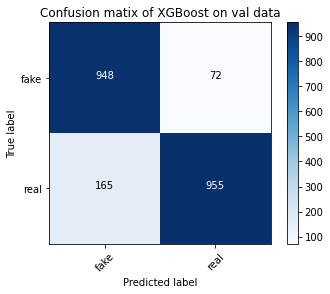

In [12]:
# XGBoost Classifier

# create pipeline
pipeline = Pipeline([
        ('bow', CountVectorizer(ngram_range=(1, 1))), # count term frequency
        ('tfidf', TfidfTransformer()), # downweight words which appear frequently
        ('c', XGBClassifier(max_depth=3, min_child_weight=3, eta = 0.15000000000000002,n_estimators = 550, scale=1, subsample =0.8500000000000001 )) # classifier
        #('c', XGBClassifier(max_depth=20, min_child_weight=2)) # classifier
        #('c', XGBClassifier(**params, objective='binary:logistic')) # classifier 
        # Best parameters: {'model__max_depth': 10, 'model__min_child_weight': 1, 'model__n_estimators': 100}
    ])

 

fit = pipeline.fit(X_train,y_train) # train model
print('XGBoost')
print ('val:')
pred = pipeline.predict(X_val) # make predictions

# display results
print_metrics(pred,y_val)
plot_confusion_matrix(confusion_matrix(y_val,pred),target_names=['fake','real'], normalize = False, \
                      title = 'Confusion matix of XGBoost on val data')

## #4 Adaptive Boost

In [16]:
# AdaBoost classifier
ada_clf = AdaBoostClassifier(n_estimators=500, random_state=0, learning_rate = 1.0)

# train model
fit = ada_clf.fit(X_train, y_train)

# make predictions
ada_pred = ada_clf.predict(X_val)

## #5 Voting Classifier

In [20]:
named_estimators = [
    ("SVM", svm_clf),
    ("Logistic Regression", lr_clf),
    ("Ada Boost", ada_clf),
    ("Gradient Boosting", gb_clf), # for each of the individual models
]

In [21]:
# voting classifier
voting_clf = VotingClassifier(named_estimators, voting = "soft") #soft voting (predicts the class label based on the argmax of the sums of the predicted probabilities)

# fit model
voting_clf.fit(X_train,y_train)

# make prediction
voting_pred = voting_clf.predict(X_val)

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


# Evaluation

In [9]:
# define print_metrics() function to print results
def print_metrics(pred,true):
    print(confusion_matrix(true,pred))
    print(classification_report(true,pred,))
    print("Accuracy : ",accuracy_score(pred,true))
    print("Precison : ",precision_score(pred,true, average = 'weighted'))
    print("Recall : ",recall_score(pred,true,  average = 'weighted'))
    print("F1 : ",f1_score(pred,true,  average = 'weighted'))

In [10]:
# define plot_confusion_matrix() function to display results
def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True):
    """
    given a sklearn confusion matrix (cm), make a nice plot

    Arguments
    ---------
    cm:           confusion matrix from sklearn.metrics.confusion_matrix

    target_names: given classification classes such as [0, 1, 2]
                  the class names, for example: ['high', 'medium', 'low']

    title:        the text to display at the top of the matrix

    cmap:         the gradient of the values displayed from matplotlib.pyplot.cm
                  see http://matplotlib.org/examples/color/colormaps_reference.html
                  plt.get_cmap('jet') or plt.cm.Blues

    normalize:    If False, plot the raw numbers
                  If True, plot the proportions

    Usage
    -----
    plot_confusion_matrix(cm           = cm,                  # confusion matrix created by
                                                              # sklearn.metrics.confusion_matrix
                          normalize    = True,                # show proportions
                          target_names = y_labels_vals,       # list of names of the classes
                          title        = best_estimator_name) # title of graph

    Citiation
    ---------
    http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html

    """

    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(5, 4))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    #plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.xlabel('Predicted label')
    plt.show()

## #1 SVM

[[ 944   76]
 [  67 1053]]
              precision    recall  f1-score   support

        fake       0.93      0.93      0.93      1020
        real       0.93      0.94      0.94      1120

    accuracy                           0.93      2140
   macro avg       0.93      0.93      0.93      2140
weighted avg       0.93      0.93      0.93      2140

Accuracy :  0.9331775700934579
Precison :  0.9332393436346501
Recall :  0.9331775700934579
F1 :  0.9331919214149245


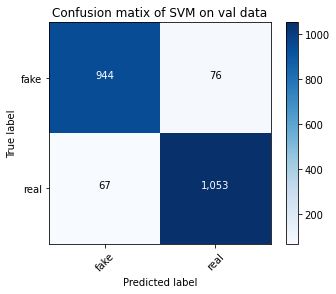

In [19]:
# display results
print_metrics(svm_pred, y_val)
plot_confusion_matrix(confusion_matrix(y_val,svm_pred),target_names=['fake','real'], normalize = False, \
                      title = 'Confusion matix of SVM on val data')

## #2 Logisitic Regression

[[ 929   91]
 [  76 1044]]
              precision    recall  f1-score   support

        fake       0.92      0.91      0.92      1020
        real       0.92      0.93      0.93      1120

    accuracy                           0.92      2140
   macro avg       0.92      0.92      0.92      2140
weighted avg       0.92      0.92      0.92      2140

Accuracy :  0.9219626168224299
Precison :  0.9221123262389068
Recall :  0.9219626168224299
F1 :  0.9219920963299126


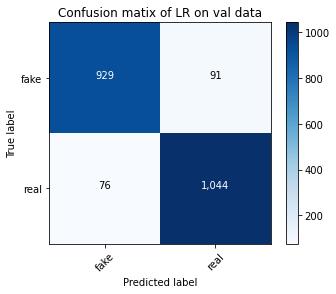

In [20]:
# display results
print_metrics(lr_pred, y_val)
plot_confusion_matrix(confusion_matrix(y_val,lr_pred),target_names=['fake','real'], normalize = False, \
                      title = 'Confusion matix of LR on val data')

## #3 Extreme Gradient Boost

[[ 904  116]
 [ 116 1004]]
              precision    recall  f1-score   support

        fake       0.89      0.89      0.89      1020
        real       0.90      0.90      0.90      1120

    accuracy                           0.89      2140
   macro avg       0.89      0.89      0.89      2140
weighted avg       0.89      0.89      0.89      2140

Accuracy :  0.891588785046729
Precison :  0.891588785046729
Recall :  0.891588785046729
F1 :  0.891588785046729


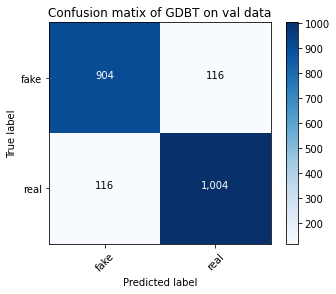

In [21]:
# display results
print_metrics(gb_pred, y_val)
plot_confusion_matrix(confusion_matrix(y_val, gb_pred),target_names=['fake','real'], normalize = False, \
                      title = 'Confusion matix of GDBT on val data')

## #4 Adaptive Boost

[[ 910  110]
 [  92 1028]]
              precision    recall  f1-score   support

        fake       0.91      0.89      0.90      1020
        real       0.90      0.92      0.91      1120

    accuracy                           0.91      2140
   macro avg       0.91      0.91      0.91      2140
weighted avg       0.91      0.91      0.91      2140

Accuracy :  0.905607476635514
Precison :  0.9058236472158957
Recall :  0.905607476635514
F1 :  0.9056513890199289


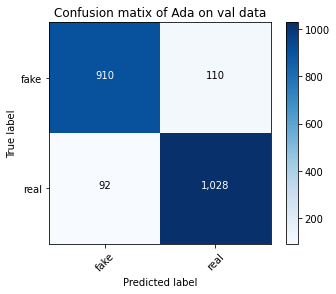

In [ ]:
#without hyperparameters: f1 = 0.8850370706902788
# display results
print_metrics(ada_pred,val['label'])
plot_confusion_matrix(confusion_matrix(val['label'],ada_pred),target_names=['fake','real'], normalize = False, \
                      title = 'Confusion matix of Ada on val data')

## #5 Voting Classifier

[[ 938   82]
 [  69 1051]]
              precision    recall  f1-score   support

        fake       0.93      0.92      0.93      1020
        real       0.93      0.94      0.93      1120

    accuracy                           0.93      2140
   macro avg       0.93      0.93      0.93      2140
weighted avg       0.93      0.93      0.93      2140

Accuracy :  0.9294392523364486
Precison :  0.9295533669075107
Recall :  0.9294392523364486
F1 :  0.9294619494185866


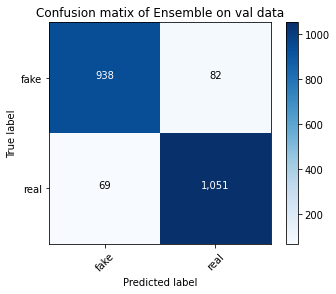

In [22]:
# display results
print_metrics(voting_pred,val['label'])
plot_confusion_matrix(confusion_matrix(val['label'],voting_pred),target_names=['fake','real'], normalize = False, \
                      title = 'Confusion matix of Ensemble on val data')

So far, simple SVM outfperforms ensemble learning

# Error Analysis

In [22]:
# create a df of misclassified posts
val_orig = pd.read_csv('https://raw.githubusercontent.com/smkerr/COVID-fake-news-detection/main/data/Constraint_Val.csv', header=0)
svm_val_misclass_df = val_orig[svm_pred!=y_val]

# inspect df
svm_val_misclass_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 143 entries, 1 to 2104
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      143 non-null    int64 
 1   tweet   143 non-null    object
 2   label   143 non-null    object
dtypes: int64(1), object(2)
memory usage: 4.5+ KB


In [ ]:
#error analysis, to compair the false classifications of the different models

false_pred_svm = val[(val["label"] != svm_pred)]
false_pred_gb = val[(val["label"] != gb_pred)]
false_pred_lr = val[(val["label"] != lr_pred)]
false_pred_xg = val[(val["label"] != pred)]
false_pred_ada = val[(val["label"] != ada_pred)]
false_pred_ensemble = val[(val["label"] != voting_pred)]

#common_mistakes = false_pred_svm = false_pred_gb = false_pred_lr = false_pred_xg = false_pred_ada = false_pred_ensemble
print(false_pred_ensemble)



        id                                              tweet label
1        2  11 13 people diamond princess cruise ship inti...  fake
10      11  still fly friendly skies without fear covid ai...  real
13      14  tomorrow april 6 pass 10000 coronavirus deaths...  real
25      26  breathlessness excessive fatigue muscle aches ...  real
28      29  everyone help prevent spread covid19 clara cor...  real
...    ...                                                ...   ...
2051  2052  missouri businesses open monday may 4 new orde...  fake
2079  2080  coronavirus sir keir starmer says second lockd...  real
2090  2091  uk government says responded well coronavirus ...  real
2104  2105  june 26 taipei veterans general hospital imple...  fake
2107  2108  icymi deborah birx 3 8 20 white house briefing...  real

[161 rows x 3 columns]


In [ ]:
#print(common_mistakes)
common_mistakes = pd.merge(false_pred_svm, false_pred_ada, on=['tweet'], how='inner')
print(common_mistakes)
common_mistakes.to_csv('/content/drive/MyDrive/Final Project/COVID-fake-news-detection/model/error_analysis/common_mistakes.csv', encoding='utf-8')

    id_x                                              tweet label_x  id_y  \
0      2  11 13 people diamond princess cruise ship inti...    fake     2   
1     11  still fly friendly skies without fear covid ai...    real    11   
2     14  tomorrow april 6 pass 10000 coronavirus deaths...    real    14   
3     56  india 3 covid19vaccine trials underway dcgi pe...    real    56   
4     56  india 3 covid19vaccine trials underway dcgi pe...    real   274   
..   ...                                                ...     ...   ...   
87  2018  u nears 2 7 million total covid 19 cases 13000...    fake  2018   
88  2044  kids covid contagious adults methodsmanmd expl...    real  2044   
89  2059  wwn brings groundbreaking reportage government...    fake  2059   
90  2080  coronavirus sir keir starmer says second lockd...    real  2080   
91  2105  june 26 taipei veterans general hospital imple...    fake  2105   

   label_y  
0     fake  
1     real  
2     real  
3     real  
4     real

In [ ]:
#mount drive to save data
from google.colab import drive
drive.mount('drive')

Mounted at drive
